In [7]:
library(dplyr)
library(tidyr)
library(broom)
library(ggrepel)
library(gridExtra)
library(foreach)
library(parallel)
library(doParallel)

# 0, .01, .1
min_prob = 0
# .5, 1, 2, 10
L_mult = 2


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: iterators


In [8]:
# load protien-glycan structure relations
#setwd('G:/My Drive/00_professional/projects/GTspecificity/')
file_protein_structure_motif05 = 'uniprot-annotation_type_carbohyd-organism_human-filtered-reviewed.tsv'
glycosites = read.table(file_protein_structure_motif05,sep='\t',header=T,fill=T,stringsAsFactors = F)[,-c(3:6)]
glycosites$Glycosylation = strsplit(glycosites$Glycosylation,split=';')
#head(UNICARB_PSTRUC_GSTRUC[,1:10])
#head(glycosites)

glycosites = separate_rows( cbind(glycosites[,1:3], sites=unlist(lapply( glycosites$Glycosylation , function(x){
  paste( as.numeric(trimws(gsub('CARBOHYD ','',x[grepl('CARB',x)]))) , collapse=',')
}))),sites)

head(glycosites)

Warning message in paste(as.numeric(trimws(gsub("CARBOHYD ", "", x[grepl("CARB", :
“NAs introduced by coercion”Warning message in paste(as.numeric(trimws(gsub("CARBOHYD ", "", x[grepl("CARB", :
“NAs introduced by coercion”Warning message in paste(as.numeric(trimws(gsub("CARBOHYD ", "", x[grepl("CARB", :
“NAs introduced by coercion”Warning message in paste(as.numeric(trimws(gsub("CARBOHYD ", "", x[grepl("CARB", :
“NAs introduced by coercion”Warning message in paste(as.numeric(trimws(gsub("CARBOHYD ", "", x[grepl("CARB", :
“NAs introduced by coercion”

Entry,Entry.name,Length,sites
<chr>,<chr>,<chr>,<chr>
Q75V66,ANO5_HUMAN,913,335
Q75V66,ANO5_HUMAN,913,366
Q75V66,ANO5_HUMAN,913,380
Q75V66,ANO5_HUMAN,913,768
Q75V66,ANO5_HUMAN,913,778
Q75V66,ANO5_HUMAN,913,791


In [6]:
  fs=list.files('EV_2005_KellyBrock_human/ec_files',full.names = T)
grep('EPO',fs,value = T)

[1] "EV_2005_KellyBrock_human/ec_files/EPO_HUMAN_full_b01_CouplingScoresCompared_all.csv"

In [9]:
rda_file=paste0('EV_2005_KellyBrock_human/EVL.rda')
if(file.exists(rda_file)){
  load(rda_file)
}else{
  
  ### load Evo Coupling structures
  #fs=system('ls GTspec_UNICARBKBevMarks_query/data/curate_output_Kellman/*/*_CouplingScores_longrange.csv',intern = T)
  
  range = 1:11
  sort_on = 'score'
  
  pb <- txtProgressBar(min = 0, max = length(fs), style = 3)
  
  
  #fs=dir('GTspec_UNICARBKBevMarks_query/data/curate_output_Kellman/',recursive = T,full.names = T,
  #       pattern = '*_CouplingScores_longrange.csv')
  
   EV = lapply(1:length(fs),function(i){
        x = fs[i]
        setTxtProgressBar(pb, i)
        tmp = NULL
        try( tmp <- read.csv(x)[,1:11] )
        if(is.null(tmp)){return(NA)}
        #tmp$protein = gsub('_.*|/','',gsub('GTspec_UNICARBKBevMarks_query/data/curate_output_Kellman/','',x))
        tmp$uniprotID = paste(gsub('_.*','',gsub('.*\\/','',x)),'HUMAN',sep='_')

        L = max(tmp$i) - min(tmp$i)
        tmp$rank_score_all = order(tmp$score,decreasing = T)/L
        tmp$rank_mad_all = order(tmp$mad_score,decreasing = T)/L
#print(colnames(tmp))
        #      tmp = tmp[order(tmp[[sort_on]],decreasing = T)[1:(L*L_mult)],]
        colnames(tmp)[1:4] = c('seq_resnum','AA_i','seq_resnum_j','AA_j')
               #,'fn','cn','segment_i','segment_j',
              #'mad_score','probability','score','uniprotID','rank_score_all','rank_mad_all')

        # get bottom half of the triangle
        tmp2 = tmp[,c(3,4,1,2,5:ncol(tmp))]
        colnames(tmp2)[1:4] = c('seq_resnum','AA_i','seq_resnum_j','AA_j')

        tmp = rbind(tmp,tmp2)

        tmp$diff =  tmp$seq_resnum_j - tmp$seq_resnum

        tmp = merge(tmp,glycosites,by.x=c('uniprotID','seq_resnum'),by.y=c('Entry.name','sites'),all.x=T)
        tmp$is_Nsite = tmp$AA_i=="N" & !is.na(tmp$Entry)

        tmp
      })
  
  EV = do.call(rbind,EV) #[,-c(7:8)]
  
  # i	A_i	j	A_j	fn	cn	segment_i	segment_j	mad_score	probability	score
  
  #colnames(EV) = c('seq_resnum','AA_i','seq_resnum_j','AA_j','fn','cn','segment_i','segment_j','mad_score','probability','score','uniprotID','rank_score','rank_mad')
  
  #EV = merge(EV,glycosites,by.x=c('uniprotID','seq_resnum'),by.y=c('Entry.name','sites'),all.x=T)
  #EV$is_Nsite = EV$AA_i=="N" & !is.na(EV$Entry)
  
  dim(EV)
  #EV = merge(EV,aa_class,all.x=T)
  dim(EV)
  save(EV,file=rda_file)
}
head(EV)


uniprotID,seq_resnum,AA_i,seq_resnum_j,AA_j,fn,cn,segment_i,segment_j,mad_score,probability,score,rank_score_all,rank_mad_all,diff,Entry,Length,is_Nsite
<chr>,<int>,<fct>,<int>,<fct>,<int>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
5HT3D_HUMAN,34,F,35,G,0,0.157643,A,A,5.845653,0.9436248,2.81770010,0.6038647,1.3212560,1,NA,NA,FALSE
5HT3D_HUMAN,34,F,36,Q,0,0.137717,A,A,5.126133,0.8766396,1.96098572,0.9420290,0.6425121,2,NA,NA,FALSE
5HT3D_HUMAN,34,F,37,H,0,0.144579,A,A,5.373917,0.8648646,1.85629592,0.9903382,0.7246377,3,NA,NA,FALSE
5HT3D_HUMAN,34,F,38,R,0,0.145298,A,A,5.399880,0.8490036,1.72680778,1.0797101,1.2971014,4,NA,NA,FALSE
5HT3D_HUMAN,34,F,40,D,0,0.094660,A,A,3.571363,0.4862544,-0.05499644,3.5628019,2.1231884,6,NA,NA,FALSE
5HT3D_HUMAN,34,F,346,H,0,0.040799,A,A,1.626466,0.4458991,-0.21725428,4.1956522,4.1086957,312,NA,NA,FALSE


In [ ]:
library(ggpubr)
### N: glycosite vs not
my_comparisons <- list( c("other", "N"), c("other", "glycosite"), c("N", "glycosite") )[c(3,1,2)]
EV$type = factor(ifelse(EV$AA_i=='N',ifelse(EV$is_Nsite,'glycosite','N'),'other'))
EV$diff_fact = cut(EV$diff,breaks=c(-Inf,-10,0,10,Inf))

# split upstream, downstream and trans

In [ ]:
### add nearest AA info

pb <- txtProgressBar(min = 0, max = length(levels(EV$AA_j)), style = 3)
i=1

#outlist = list()
EV_nearest=do.call(cbind,lapply(levels(EV$AA_j),function(aa_j) {
    setTxtProgressBar(pb, i)
    i<<-i+1

    tmp=EV %>% 
        group_by(uniprotID,seq_resnum,AA_i) %>%
#         mutate( aa_present = sum(AA_j==aa_j)) %>% filter(aa_present>0,.preserve = T) %>% ## filter to just 
#         mutate( seq_diff_j = seq_resnum_j[AA_j==aa_j]-seq_resnum[AA_j==aa_j] ) %>%
#         mutate( nearest_aa_j = seq_diff_j[which.min(seq_diff_j)^2] )
        mutate(nearest_aa_j = ifelse(sum(AA_j==aa_j)>0,
            (seq_resnum_j[AA_j==aa_j]-seq_resnum[AA_j==aa_j])[which.min(( seq_resnum_j[AA_j==aa_j]-seq_resnum[AA_j==aa_j])^2 )], NA )) 
    tmp$nearest_aa_j
#     if(nrow(tmp)!=nrow(EV)){stop("dimensions dont match")}
#     EV[paste0('Nearest_',aa_j)] = tmp$nearest_aa_j
}))

colnames(EV_nearest) = paste0('Nearest_', levels(EV$AA_j))
EV = cbind(EV,EV_nearest)

save(EV_nearest,file=gsub('.rda',',nearest_aa.rda',rda_file)) 



In [7]:
head(EV)

uniprotID,seq_resnum,AA_i,seq_resnum_j,AA_j,fn,cn,segment_i,segment_j,mad_score,probability,score,rank_score_all,rank_mad_all,diff,Entry,Length,is_Nsite,type,diff_fact
<chr>,<int>,<fct>,<int>,<fct>,<int>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>,<fct>,<fct>
5HT3D_HUMAN,34,F,35,G,0,0.157643,A,A,5.845653,0.9436248,2.81770010,0.6038647,1.3212560,1,NA,NA,FALSE,other,"(0,10]"
5HT3D_HUMAN,34,F,36,Q,0,0.137717,A,A,5.126133,0.8766396,1.96098572,0.9420290,0.6425121,2,NA,NA,FALSE,other,"(0,10]"
5HT3D_HUMAN,34,F,37,H,0,0.144579,A,A,5.373917,0.8648646,1.85629592,0.9903382,0.7246377,3,NA,NA,FALSE,other,"(0,10]"
5HT3D_HUMAN,34,F,38,R,0,0.145298,A,A,5.399880,0.8490036,1.72680778,1.0797101,1.2971014,4,NA,NA,FALSE,other,"(0,10]"
5HT3D_HUMAN,34,F,40,D,0,0.094660,A,A,3.571363,0.4862544,-0.05499644,3.5628019,2.1231884,6,NA,NA,FALSE,other,"(0,10]"
5HT3D_HUMAN,34,F,346,H,0,0.040799,A,A,1.626466,0.4458991,-0.21725428,4.1956522,4.1086957,312,NA,NA,FALSE,other,"(10, Inf]"


In [324]:
# ### add nearest AA info

#   pb <- txtProgressBar(min = 0, max = length(levels(EV$AA_j)), style = 3)
# i=1

# get_nearest<-function(seq_resnum,seq_resnum_j,AA_j,aa_j){
#     #if(sum(AA_j==aa_j)==0){return(NULL)}
#     tryCatch(
#         (seq_resnum_j[AA_j==aa_j]-seq_resnum[AA_j==aa_j])[which.min(( seq_resnum_j[AA_j==aa_j]-seq_resnum[AA_j==aa_j])^2 )],
#         error = function(e) NA
# }

# for(aa_j in levels(EV$AA_j)[-1]){
#     setTxtProgressBar(pb, i)
#     tmp= EV[1] %>% group_by(uniprotID,seq_resnum,AA_i) %>%
#         mutate(nearest_aa_j = get_nearest(seq_resnum,seq_resnum_j,AA_j,aa_j) )
#     EV[paste0('Nearest_',aa_j)] = tmp$nearest_aa_j
#     i=i+1
# }

#   save(EV,file=rda_file)


In [284]:
sumry_f = median # function(x) quantile(x,.75)
p_adj = function(x) p.adjust(x,method = 'fdr')

### aggregate wilcox scores 

################# score

tmp=do.call(rbind,lapply(c(.3,.5,1,2,3,4),function(i){
    signf=EV %>%
        filter(rank_score_all<i & diff>=(-6) & diff<=6 ) %>%
        group_by(AA_j,diff) %>% 
        filter(length(plog[type=='glycosite'])>2 & length(plog[type=='N'])>2) %>%
            summarize(pW_glyco_v_n=(wilcox.test(plog[type=='glycosite'],plog[type=='N'],alternative = 'greater')$p.value),
                    fc_glyco_v_n=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='N'])),
                    pW_glyco_v_other=(wilcox.test(plog[type=='glycosite'],plog[type=='other'],alternative = 'greater')$p.value),
                    fc_glyco_v_other=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='other']))) %>%
            mutate(thresh=i)
    signf = signf %>% group_by(AA_j,thresh) %>% 
        mutate(fdrW_glyco_v_n = p_adj(pW_glyco_v_n)) %>%
        mutate(fdrW_glyco_v_other = p_adj(pW_glyco_v_other))
    }))


#################### mad

tmp2=do.call(rbind,lapply(c(.3,.5,1,2,3,4),function(i){
    signf=EV %>%
        filter(rank_mad_all<i & diff>=(-6) & diff<=6 ) %>%
        group_by(AA_j,diff) %>% 
        filter(length(plog[type=='glycosite'])>2 & length(plog[type=='N'])>2) %>%
            summarize(pW_glyco_v_n=(wilcox.test(plog[type=='glycosite'],plog[type=='N'],alternative = 'greater')$p.value),
                    fc_glyco_v_n=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='N'])),
                    pW_glyco_v_other=(wilcox.test(plog[type=='glycosite'],plog[type=='other'],alternative = 'greater')$p.value),
                    fc_glyco_v_other=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='other']))) %>%
            mutate(thresh=i)
    signf = signf %>% group_by(AA_j,thresh) %>% 
        mutate(fdrW_glyco_v_n = p_adj(pW_glyco_v_n)) %>%
        mutate(fdrW_glyco_v_other = p_adj(pW_glyco_v_other))
    }))



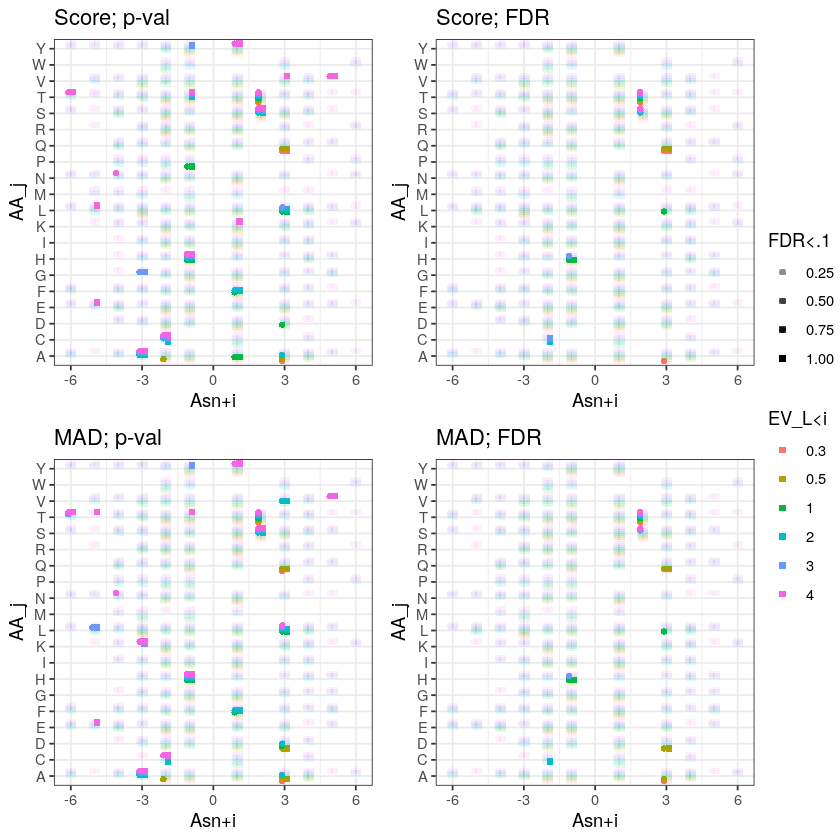

In [296]:
################
#plots
################

p_width=.75
cutoff=.1

g_fdr_score = ggplot(tmp,aes(color=factor(thresh),y=AA_j))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(fdrW_glyco_v_n<cutoff,1,.1)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(fdrW_glyco_v_other<cutoff,1,.1)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('Score; FDR')+
    theme_bw()+theme(legend.position = "none")

p_width=.75
cutoff=.05

g_p_score = ggplot(tmp,aes(color=factor(thresh),y=AA_j))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(pW_glyco_v_n<cutoff,1,.1)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(pW_glyco_v_other<cutoff,1,.1)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('Score; p-val')+
    theme_bw()+theme(legend.position = "none")

#####

p_width=.75
cutoff=.1

g_fdr_mad=ggplot(tmp2,aes(color=factor(thresh),y=AA_j))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(fdrW_glyco_v_n<cutoff,1,.1)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(fdrW_glyco_v_other<cutoff,1,.1)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('MAD; FDR')+
    theme_bw()+theme(legend.position = "none")

p_width=.75
cutoff=.05

g_p_mad=ggplot(tmp2,aes(color=factor(thresh),y=AA_j))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(pW_glyco_v_n<cutoff,1,.1)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(pW_glyco_v_other<cutoff,1,.1)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('MAD; p-val')+
    theme_bw()


###############
library(cowplot)
#g = grid.arrange(grobs=list(g_p_score,g_fdr_score,g_p_mad,g_fdr_mad),nrow=2)

legend = get_legend(g_p_mad)
# build grid without legends
pgrid <- plot_grid(g_p_score,g_fdr_score,g_p_mad+theme(legend.position = "none"),g_fdr_mad, ncol = 2)
# add legend
p <- plot_grid(pgrid, legend, ncol = 2, rel_widths = c(1, .1))
p
ggsave(p,filename = 'figures/aggregated_wilcox.by_AAj.by_diff.pdf',height=15,width=15)
write.csv(tmp,file='wilcox.by_score.csv')
write.csv(tmp2,file='wilcox.by_mad.csv')

In [334]:
#### plus "nearest"

sumry_f = median # function(x) quantile(x,.75)
p_adj = function(x) p.adjust(x,method = 'fdr')

### aggregate wilcox scores // nearest_A

################# score

tmp=do.call(rbind,lapply(c(.3,.5,1,2,3,4),function(i){
    signf=EV %>%
        filter(rank_score_all<i & diff>=(-6) & diff<=6 ) %>%
        group_by(AA_j,diff,Nearest_A) %>% 
        filter(length(plog[type=='glycosite'])>2 & length(plog[type=='N'])>2) %>%
            summarize(pW_glyco_v_n=(wilcox.test(plog[type=='glycosite'],plog[type=='N'],alternative = 'greater')$p.value),
                    fc_glyco_v_n=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='N'])),
                    pW_glyco_v_other=(wilcox.test(plog[type=='glycosite'],plog[type=='other'],alternative = 'greater')$p.value),
                    fc_glyco_v_other=(sumry_f(plog[type=='glycosite'])/sumry_f(plog[type=='other']))) %>%
            mutate(thresh=i)
    signf = signf %>% group_by(AA_j,thresh) %>% 
        mutate(fdrW_glyco_v_n = p_adj(pW_glyco_v_n)) %>%
        mutate(fdrW_glyco_v_other = p_adj(pW_glyco_v_other))
    }))




ERROR: Error in head.default(): argument "x" is missing, with no default


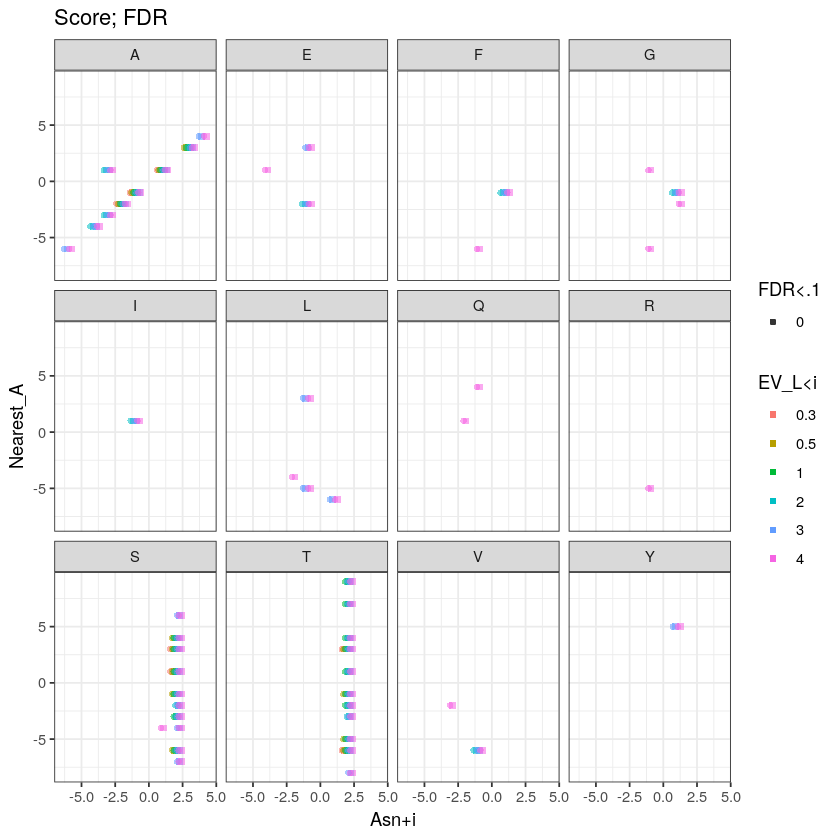

In [344]:
################
#plots
################

p_width=.75
cutoff=.1

g_fdr_score = ggplot(tmp[abs(tmp$Nearest_A)<10,],aes(color=factor(thresh),y=Nearest_A))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(fdrW_glyco_v_n<cutoff,1,0)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(fdrW_glyco_v_other<cutoff,1,0)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('Score; FDR')+
    theme_bw()+facet_wrap(~AA_j)#+theme(legend.position = "none")

p_width=.75
cutoff=.05

g_p_score = ggplot(tmp[abs(tmp$Nearest_A)<10,],aes(color=factor(thresh),y=Nearest_A))+ #=-log10(min_fdr)))+
    geom_point(aes(x=diff+.1,alpha=ifelse(pW_glyco_v_n<cutoff,1,0)),position=position_dodge(width=p_width),shape=15)+
    geom_point(aes(x=diff-.1,alpha=ifelse(pW_glyco_v_other<cutoff,1,0)),position=position_dodge(width=p_width),shape=16)+
    scale_alpha(name='FDR<.1')+scale_color_hue(name='EV_L<i')+xlab('Asn+i')+ggtitle('Score; p-val')+
    theme_bw()+facet_wrap(~AA_j)#+theme(legend.position = "none")

g_fdr_score

###############
library(cowplot)
# #g = grid.arrange(grobs=list(g_p_score,g_fdr_score,g_p_mad,g_fdr_mad),nrow=2)

# legend = get_legend(g_p_score)
# # build grid without legends
# pgrid <- plot_grid(g_p_score+theme(legend.position = "none"),g_fdr_score, ncol = 2)
# # add legend
# p <- plot_grid(pgrid, legend, ncol = 2, rel_widths = c(1, .1))
# p
# ggsave(p,filename = 'figures/aggregated_wilcox.by_AAj.by_diff.pdf',height=15,width=15)
# write.csv(tmp,file='wilcox.by_score.csv')
# write.csv(tmp2,file='wilcox.by_mad.csv')